# **Data analysis**

## **Training set**

In [1]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 40.5 MB/s eta 0:00:00


In [2]:
from Bio import SeqIO
import pandas as pd

In [40]:
neg_cols = ['ID', 'Organism_name', 'Kingdom', 'Sequence_length', 'Transmembrane']
negatives = pd.read_csv('training_set_neg.tsv', sep='\t', names=neg_cols)
negatives.shape

(7147, 5)

In [41]:
pos_cols = ['ID', 'Organism_name', 'Kingdom', 'Sequence_length', 'Signal_peptide']
positives = pd.read_csv('training_set_pos.tsv', sep='\t', names=pos_cols)
positives.shape

(874, 5)

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## **Comparison between sequence length in positive and negative entries**

In [43]:
negatives['Log_seq_len'] = np.log10(negatives['Sequence_length'])
positives['Log_seq_len'] = np.log10(positives['Sequence_length'])

In [44]:
negatives["Source"] = "negatives"
positives["Source"] = "positives"
training = pd.concat([negatives[['Log_seq_len', 'Source']], positives[['Log_seq_len', 'Source']]], ignore_index=True)

In [45]:
training.head(10)

,Log_seq_len,Source
0,2.621176,negatives
1,2.326336,negatives
2,2.805501,negatives
3,2.731589,negatives
4,2.717671,negatives
5,2.330414,negatives
6,2.707570,negatives
7,2.593286,negatives
8,2.819544,negatives
9,2.356026,negatives


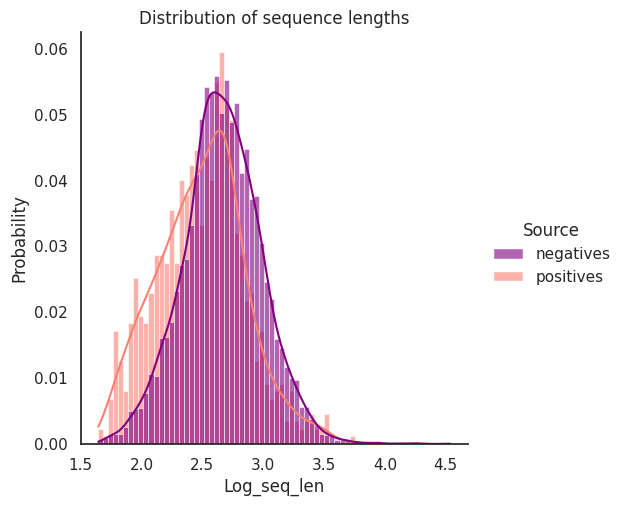

In [78]:
name = 'Hist_seqlen_pos_vs_neg.png'
sns.set_theme()
sns.set_theme(context='notebook',
 style='white',
 palette=['purple','salmon'],
 font='sans-serif',
 font_scale=1,
 color_codes=True,
)
sns.displot(data = training, hue='Source', x = 'Log_seq_len', kde = True, common_norm=False, stat='probability', alpha=0.6)
plt.title('Distribution of sequence lengths')
plt.savefig(name, dpi=500, format='png')
plt.show()


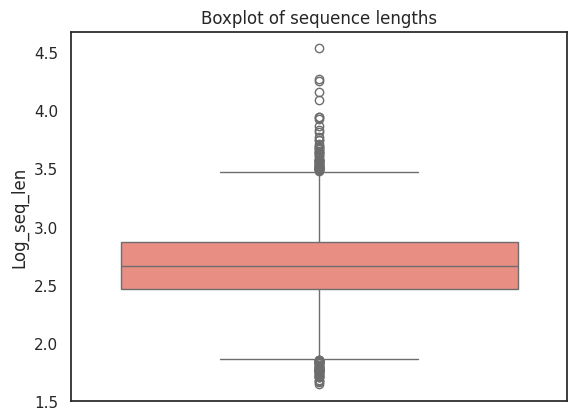

In [79]:
name_b = 'Box_seqlen_pos_vs_neg.png'
sns.boxplot(data = negatives, y = 'Log_seq_len', color='salmon')
plt.title('Boxplot of sequence lengths')
plt.savefig(name_b, dpi=500, format='png')
plt.show()


## **Distribution of SP lengths**

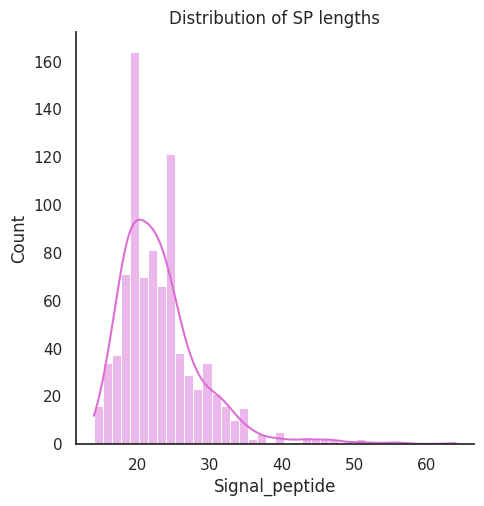

In [80]:
name_b = 'Hist_SP.png'
sns.set_theme()
sns.set_theme(context='notebook',
 style='white',
 palette=['orchid'],
 font='sans-serif',
 font_scale=1,
 color_codes=True,
)
sns.displot(data = positives, x = 'Signal_peptide', kde = True)
plt.title('Distribution of SP lengths')
plt.savefig(name_b, dpi=500, format='png')
plt.show()

## **Comparison of the amminoacid composition of SPs between our dataset and SwissProt data**

In [49]:
records = SeqIO.parse("cluster-results_rep_seq.fasta", "fasta")
data = {
    "id": [],
    "sequence": []
}
for record in records:
    data["id"].append(record.id)
    data["sequence"].append(str(record.seq))
pos_seqs = pd.DataFrame(data)

In [50]:
new_pos = pos_seqs.merge(positives[['ID','Signal_peptide']], how='inner', left_on='id', right_on='ID')
new_pos = new_pos.drop(columns=['ID'])
new_pos.tail(19)

,id,sequence,Signal_peptide
855,C0HL38,MIYQVVLLLLVSPAPVSAAGCNPDCTGIQCGWPRCPGGQNPVMDKC...,19
856,C4NZN9,MRVLLILVSLAALAHAESFLKSKTGYQGVQTLPGFIGGSQPHLGGG...,16
857,G1CWH6,MAYVRLACLAVIFFFAASVMFTVEAGIPCGESCVFIPCISSVVGCS...,25
858,O42720,MLFSKVIAPAFILLGAASAAPGGLAPENASKRDQPSVGDAFDKYNE...,32
859,O59896,MSRFQSLLSFVLVSLAAVANAAIGPVADLTLTNAAVSPDGFSREAV...,21
860,O76942,MKGISKILSASIALMKLENVYSATALCSNAYGLTPGQQGMAQQPSY...,22
861,O93233,MKSSVPSLLIACLVMSLNSYTQQVLYCPPTPAPENVTEFVCNSPSL...,23
862,Q2U4L7,MMHFLSFCLSVASLVSYAGAASTFSPARPPALPLAVKSPYLSTWLS...,20
863,Q5EPH2,MAATLPVFAVVFFAMVLASSQANECVSKGFGCLPQSDCPQEARLSY...,22
864,Q6RG02,MTTSTLLFVLAFVAGGLAAPWGADVPRCSTECPVTGSPKLAYQPDK...,18


In [51]:
def cut_sp_sequence(row):
    return str(row['sequence'])[:row['Signal_peptide']]
new_pos['sequence'] = new_pos.apply(cut_sp_sequence, axis=1)
all_seq = new_pos['sequence'].str.cat()
all_seq = pd.Series(list(all_seq))
all_seq = all_seq[all_seq != 'X']
frequences = all_seq.value_counts(normalize=True) * 100
print(frequences)


L    22.615225
A    13.975201
V     7.617448
S     7.553228
G     6.471373
M     6.090994
F     4.752260
P     4.520081
T     4.366942
I     4.124883
R     3.487625
C     2.860248
Q     2.158771
W     2.069851
K     2.035271
E     1.309095
H     1.121375
Y     1.032456
N     1.002816
D     0.834856
Name: proportion, dtype: float64


In [81]:
aa_freq = {
    'A': 8.25, 'Q': 3.93, 'L': 9.64, 'S': 6.65,
    'R': 5.52, 'E': 6.71, 'K': 5.79, 'T': 5.36,
    'N': 4.06, 'G': 7.07, 'M': 2.41, 'W': 1.10,
    'D': 5.46, 'H': 2.27, 'F': 3.86, 'Y': 2.92,
    'C': 1.38, 'I': 5.90, 'P': 4.74, 'V': 6.85
}
swissprot_freq = pd.Series(aa_freq)
print(swissprot_freq)


A    8.25
Q    3.93
L    9.64
S    6.65
R    5.52
E    6.71
K    5.79
T    5.36
N    4.06
G    7.07
M    2.41
W    1.10
D    5.46
H    2.27
F    3.86
Y    2.92
C    1.38
I    5.90
P    4.74
V    6.85
dtype: float64


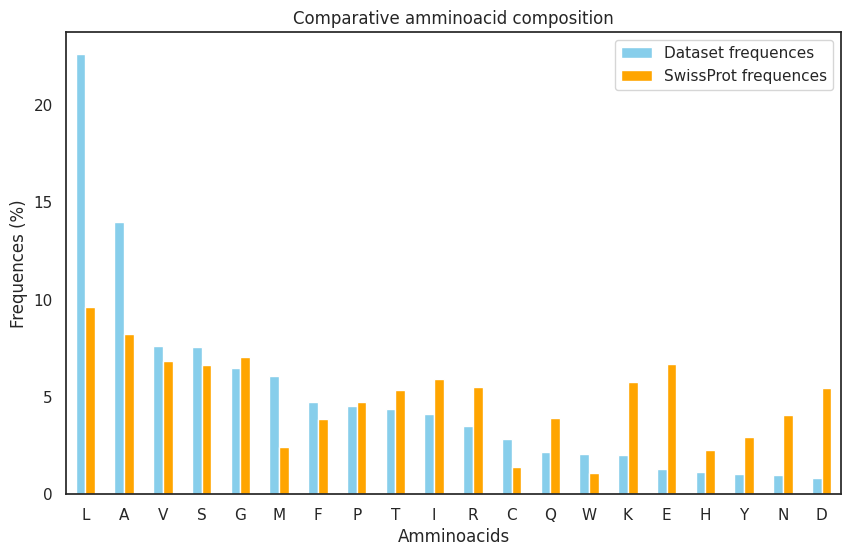

In [82]:
df = pd.concat([frequences, swissprot_freq], axis=1)
ax = df.plot(kind="bar", figsize=(10,6), color=['skyblue', 'orange'])
ax.legend(['Dataset frequences', 'SwissProt frequences'])
ax.set_ylabel("Frequences (%)")
ax.set_xlabel("Amminoacids")
ax.set_title("Comparative amminoacid composition")
plt.xticks(rotation=0)
plt.show()

## **Taxonomic classification at kingdom and species level**

In [55]:
training_set = pd.concat([negatives[['ID','Organism_name', 'Kingdom']], positives[['ID','Organism_name', 'Kingdom']]], ignore_index=True)
training_set.shape
training_set.head()

,ID,Organism_name,Kingdom
0,Q6YN16,Homo sapiens,Metazoa
1,Q9NTK1,Homo sapiens,Metazoa
2,P50542,Homo sapiens,Metazoa
3,P49419,Homo sapiens,Metazoa
4,Q9Y3I1,Homo sapiens,Metazoa


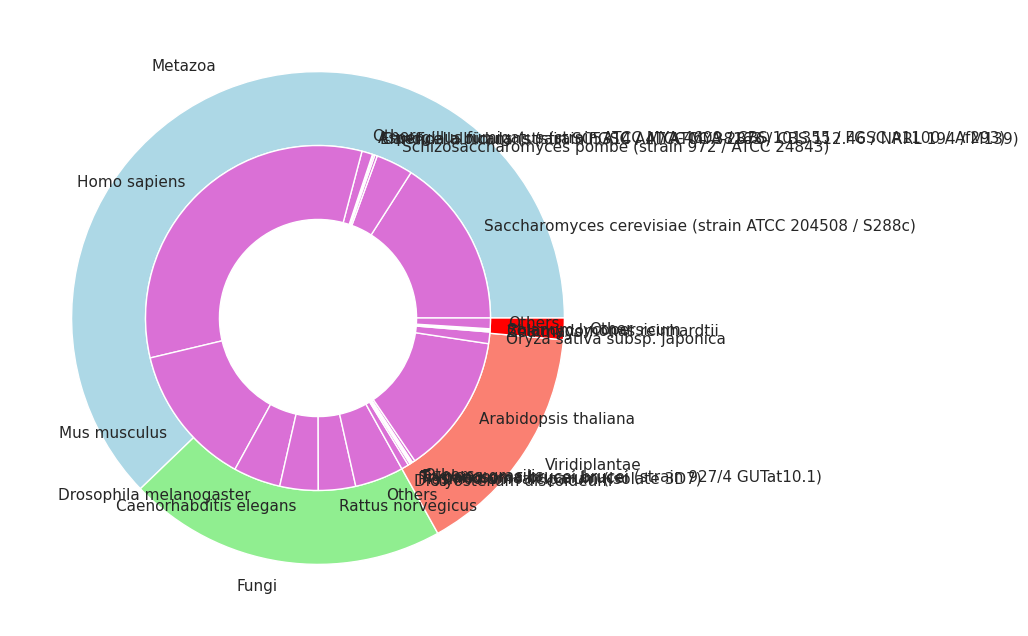

In [83]:
kingdom_count = training_set['Kingdom'].value_counts()
species_count = training_set.groupby(['Kingdom', 'Organism_name']).size()

outer_colors = ['lightblue', 'lightgreen', 'salmon','red']
species_labels = [idx[1] for idx in species_count.index]

top_n = 5
species_top = []

for kingdom, group in species_count.groupby(level=0):
    top = group.nlargest(top_n)
    others = group.sum() - top.sum()
    species_top.extend(top.tolist())
    if others > 0:
        species_top.append(others)

labels = []
for kingdom, group in species_count.groupby(level=0):
    top = group.nlargest(top_n)
    labels.extend([idx[1] for idx in top.index])
    others = group.sum() - top.sum()
    if others > 0:
        labels.append('Others')

fig, ax = plt.subplots(figsize=(8,8))

ax.pie(kingdom_count, labels=kingdom_count.index, radius=1, colors=outer_colors, wedgeprops=dict(width=0.3, edgecolor='w'))
ax.pie(species_top, labels=labels, radius=0.7, wedgeprops=dict(width=0.3, edgecolor='w'))
plt.show()